In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import pickle
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("../Data/amazon.csv")

In [3]:
df.shape

(1465, 11)

In [4]:
df.columns.to_list()

['product_id',
 'product_name',
 'category',
 'discounted_price',
 'actual_price',
 'discount_percentage',
 'rating',
 'rating_count',
 'about_product',
 'user_id',
 'user_name']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
dtypes: object(11)
memory usage: 126.0+ KB


In [6]:
df.isna().sum()

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
dtype: int64

In [7]:
df['rating_count'] = df['rating_count'].fillna(0)

In [8]:
df.isna().sum()

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           0
about_product          0
user_id                0
user_name              0
dtype: int64

In [9]:
df['text'] = df['product_name']+" "+df['category']+" "+df['about_product']

In [10]:
df = df.drop_duplicates(subset=['product_id']).reset_index(drop=True)

In [11]:
print("Remaining instences after removing duplicate data: ",df.shape[0])

Remaining instences after removing duplicate data:  1351


In [12]:
#Data for collaborative filtering
cf_ratings = df[['user_id','product_id','rating']]
print("Collaborative filtering dataset shape: ",cf_ratings.shape)

Collaborative filtering dataset shape:  (1351, 3)


In [13]:
display(df.head())

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,text
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...",Wayona Nylon Braided USB to Lightning Fast Cha...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...",Ambrane Unbreakable 60W / 3A Fast Charging 1.5...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...",Sounce Fast Phone Charging Cable & Data Sync U...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,₹329,₹699,53%,4.2,"94,363",The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...",boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,₹154,₹399,61%,4.2,"16,905",[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...",Portronics Konnect L 1.2M Fast Charging 3A 8 P...


In [14]:
display(cf_ratings.head())

,user_id,product_id,rating
0,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...",B07JW9H4J1,4.2
1,"AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...",B098NS6PVG,4
2,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...",B096MSW6CT,3.9
3,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...",B08HDJ86NZ,4.2
4,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...",B08CF3B7N1,4.2


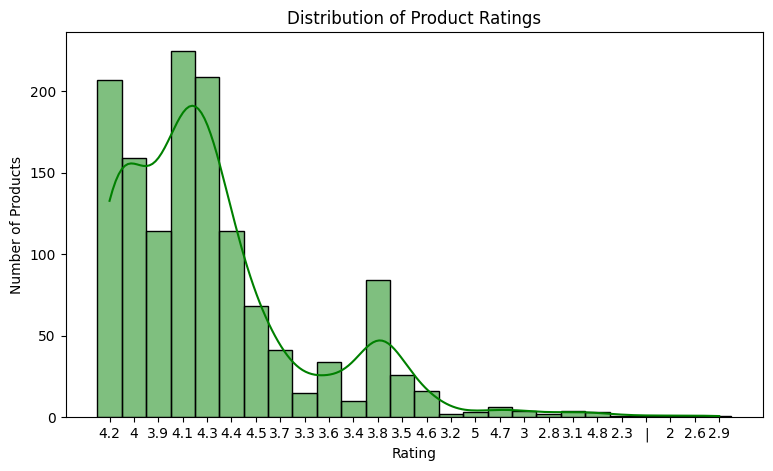

In [15]:
plt.figure(figsize=(9,5))
sns.histplot(df['rating'],
            color='green',
            bins=20,
            kde=True)
plt.title("Distribution of Product Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Products")
plt.show()

In [16]:
df['rating_count'] = pd.to_numeric(df['rating_count'],errors='coerce').fillna(0).astype(int)

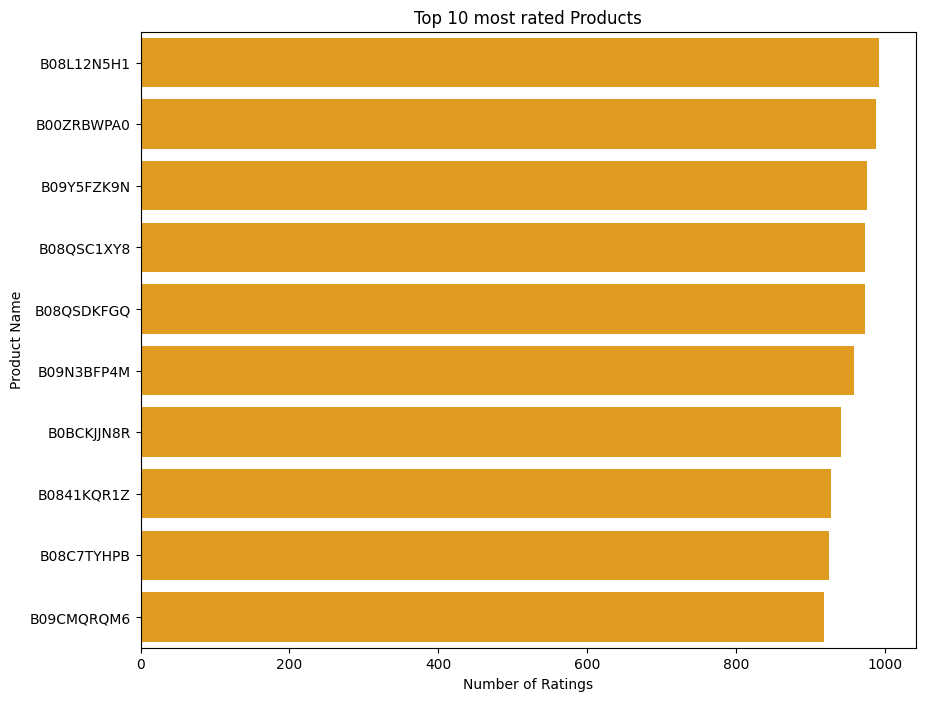

In [17]:
top_rated_products = df.sort_values(by='rating_count',ascending=False).head(10)
plt.figure(figsize=(10,8))
sns.barplot(y='product_id',
            x='rating_count',
           data=top_rated_products,
           color="orange")
plt.title("Top 10 most rated Products")
plt.ylabel("Product Name")
plt.xlabel("Number of Ratings")
plt.show()

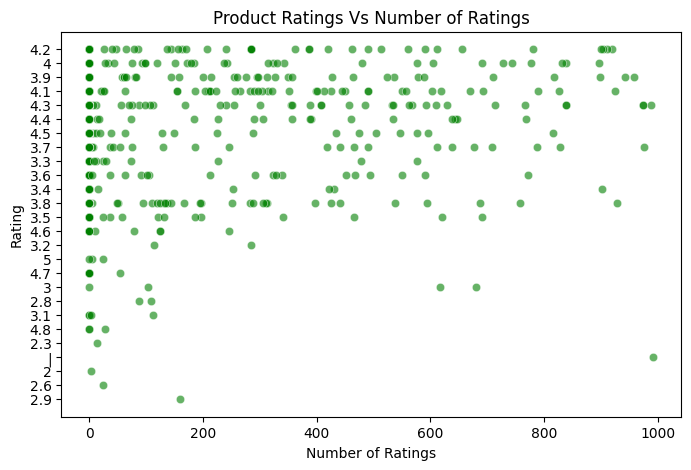

In [18]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df,
            x='rating_count',
            y='rating',
            alpha=0.6,
               color='green')
plt.title("Product Ratings Vs Number of Ratings")
plt.xlabel("Number of Ratings")
plt.ylabel("Rating")
plt.show()

In [22]:
df.head()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,text
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,0,High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...",Wayona Nylon Braided USB to Lightning Fast Cha...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4,0,"Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...",Ambrane Unbreakable 60W / 3A Fast Charging 1.5...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,0,【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...",Sounce Fast Phone Charging Cable & Data Sync U...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,₹329,₹699,53%,4.2,0,The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...",boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,₹154,₹399,61%,4.2,0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...",Portronics Konnect L 1.2M Fast Charging 3A 8 P...


In [36]:
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

In [38]:
df['popularity_score'] = df['rating']*np.log1p(df['rating_count'])*(1+df['discount_percentage']/100)
top_popular_products = df.sort_values(by='popularity_score',ascending=False).head(10)
display(top_popular_products[['product_id', 'product_name','rating', 'rating_count','discount_percentage','popularity_score' ]])

,product_id,product_name,rating,rating_count,discount_percentage,popularity_score
227,B0718ZN31Q,Rts™ High Speed 3D Full HD 1080p Support (10 M...,4.2,910,88.0,53.807631
687,B08PFSZ7FH,STRIFF Laptop Stand Adjustable Laptop Computer...,4.2,903,80.0,51.459630
552,B0BNXFDTZ2,"Fire-Boltt Tank 1.85"" Bluetooth Calling Smart ...",4.4,768,75.0,51.167200
114,B09TT6BFDX,Cotbolt Silicone Protective Case Cover for LG ...,4.5,505,80.0,50.434947
498,B0B8CHJLWJ,Kyosei Advanced Tempered Glass Compatible with...,4.5,596,75.0,50.336347
151,B08QSDKFGQ,Zoul USB Type C Fast Charging 3A Nylon Braided...,4.3,974,69.0,50.014673
538,B0B5YBGCKD,POPIO Tempered Glass Compatible for iPhone 13 ...,4.3,714,75.0,49.456426
32,B08QSC1XY8,Zoul USB C 60W Fast Charging 3A 6ft/2M Long Ty...,4.3,974,65.0,48.830894
604,B0B9LDCX89,STRIFF Mpad Mouse Mat 230X190X3mm Gaming Mouse...,4.2,491,87.0,48.682852
107,B0981XSZJ7,CROSSVOLT Compatible Dash/Warp Data Sync Fast ...,4.3,766,70.0,48.556579


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1351 non-null   object 
 1   product_name         1351 non-null   object 
 2   category             1351 non-null   object 
 3   discounted_price     1351 non-null   object 
 4   actual_price         1351 non-null   object 
 5   discount_percentage  1351 non-null   float64
 6   rating               1350 non-null   float64
 7   rating_count         1351 non-null   int64  
 8   about_product        1351 non-null   object 
 9   user_id              1351 non-null   object 
 10  user_name            1351 non-null   object 
 11  text                 1351 non-null   object 
 12  popularity_score     1350 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 137.3+ KB


In [45]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df['user_id'] = user_encoder.fit_transform(df['user_id'])
df['product_id'] = item_encoder.fit_transform(df['product_id'])

In [61]:
user_item_matrix = df.pivot_table(
    index='user_id',
    columns='product_id',
    values='rating',
    fill_value=0
)
print("User-Item Matrix shape: ", user_item_matrix.shape)
user_item_matrix.iloc[330:350, 900:1050]

User-Item Matrix shape:  (1185, 1350)


product_id,901,902,903,904,905,906,907,908,909,910,...,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050
user_id,,,,,,,,,,,,,,,,,,,,,
330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
(user_item_matrix != 0).sum().sum()

np.int64(1350)

In [64]:
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd.fit_transform(user_item_matrix)
item_factors = svd.components_.T

print("User Factor Shape: ",user_factors.shape)
print("Item Factor Shape: ",item_factors.shape)

User Factor Shape:  (1185, 50)
Item Factor Shape:  (1350, 50)


In [65]:
predicted_ratings = np.dot(user_factors, item_factors.T)
predicted_ratings.shape

(1185, 1350)

In [66]:
def recommend_products_cf(user_id, num_recs=5):
    # Get encoded user index
    user_idx = user_id

    # Get predicted scores for this user
    user_scores = predicted_ratings[user_idx]

    # Sort product indices by score
    top_items_idx = np.argsort(user_scores)[::-1]

    # Decode product IDs back to original form
    recommended_products = item_encoder.inverse_transform(top_items_idx[:num_recs])

    return recommended_products

In [67]:
df['user_id'].unique()[:10]

array([ 618,   88,  843,  251,   17,  207,  657, 1154,  853,  885])

In [71]:
recommend_products_cf(251,num_recs=5)

array(['B08HDJ86NZ', 'B08HDH26JX', 'B07CRL2GY6', 'B0789LZTCJ',
       'B08HF4W2CT'], dtype=object)

In [72]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['text'])

In [73]:
content_sim = cosine_similarity(tfidf_matrix)

In [74]:
def recommend_products_content(product_id, num_recs=5):
    try:
        idx = df[df['product_id'] == product_id].index[0]
    except:
        return "Product ID not found"
        
    similarity_scores = list(enumerate(content_sim[idx]))
    sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    top_indices = [i[0] for i in sorted_scores[1:num_recs+1]]
    return df.iloc[top_indices][['product_id', 'product_name', 'category']]

In [76]:
recommend_products_content(902,num_recs=5)

,product_id,product_name,category
1143,641,Eureka Forbes Active Clean 700 Watts Powerful ...,"Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle..."
1165,669,Eureka Forbes car Vac 100 Watts Powerful Sucti...,"Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle..."
984,119,Eureka Forbes Trendy Zip 1000 Watts powerful s...,"Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle..."
1224,325,AmazonBasics Cylinder Bagless Vacuum Cleaner w...,"Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle..."
1045,494,Eureka Forbes Wet & Dry Ultimo 1400 Watts Mult...,"Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle..."
